In [1]:
import os
os.chdir("../..")
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests
# !pip install google-api-python-client
from googleapiclient.discovery import build

# local import
from scripts.python.config import GoogleAPIkey

In [2]:
def service(developerKey: str):
    return build('trends', 'v1beta', developerKey=developerKey)


def get(method, params, developerKey):
    conn = service(developerKey)
    if method not in ['getGraph', 'getTimelinesForHealth']:
        raise NotImplementedError("Method not supported.")
    else:
        return getattr(conn, method)(**params).execute()

## Case-sensitive testing

In [3]:
upper_parms = {
    'terms': "Papua New Guinea",
    'restrictions_geo': "AU",
    'restrictions_startDate': "2004-01"
}

# change terms to lower case
lower_parms = upper_parms.copy()
lower_parms["terms"] = lower_parms["terms"].lower()

upper = get(method="getGraph", params=upper_parms, developerKey=GoogleAPIkey)
lower = get(method="getGraph", params=lower_parms, developerKey=GoogleAPIkey)

# test whether keyword is case-sensitive
assert upper["lines"][0]["points"] == lower["lines"][0]["points"], "Keyword is sensitive."

In [4]:
# Transform to df
kw_png = pd.json_normalize(upper["lines"],
                           meta=["term"],
                           record_path=["points"])
kw_png.head(5)

,value,date,term
0,57,2004-01-01,Papua New Guinea
1,97,2004-02-01,Papua New Guinea
2,71,2004-03-01,Papua New Guinea
3,57,2004-04-01,Papua New Guinea
4,73,2004-05-01,Papua New Guinea


## Downloading files

In [11]:
geos = ["AU", "NZ", "US", "JP", "HK", "SB"]
params = {
    "terms": "fiji flights",
    "restrictions_geo": "",
    "restrictions_startDate": "2004-01"
}


df = pd.DataFrame()
df["date"] = pd.date_range(start="2004-01-01", end="2022-10-01", freq="MS")

for geo in geos:
    params["restrictions_geo"] = geo
    geo_raw = get(method="getGraph", params=params, developerKey=GoogleAPIkey)
    geo_df = pd.json_normalize(geo_raw["lines"], meta=[
                               "term"], record_path=["points"])
    geo_df["date"] = pd.to_datetime(geo_df["date"])
    geo_df = geo_df.rename({"value": geo}, axis=1).drop("term", axis=1)
    df = pd.merge(df, geo_df, how="left", on="date")
    
df.to_csv(os.getcwd() + "/data/tourism/trends/trends_fiji.csv", encoding="utf-8")

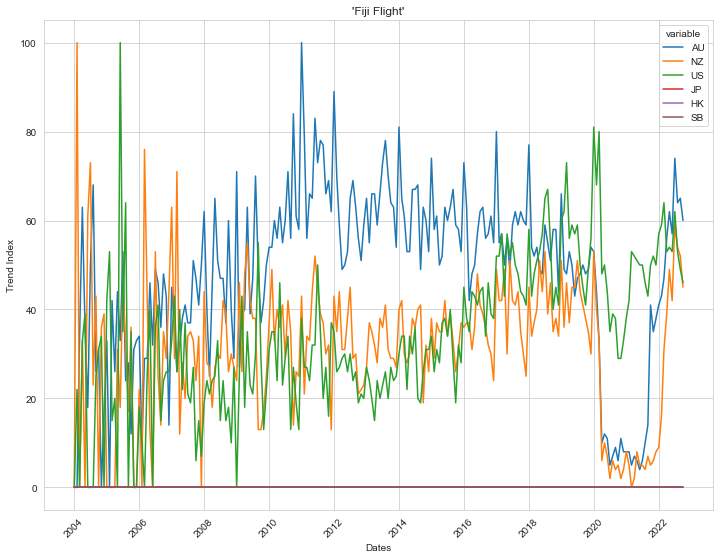

In [16]:
import seaborn as sns

viz_df = pd.melt(df, "date")
viz_df["value"] = viz_df["value"].astype(float)

plt.figure(figsize=(12,9)) 
sns.set_style("whitegrid")
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
plt.xlabel("Dates")
plt.ylabel("Trend Index")
plt.title("'Fiji Flight'")
plt.xticks(rotation=45)
plt.show()